Importing libraries

In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#setup matplot's deafults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [3]:
#import data preprocessing libraries
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [4]:
#import feature engineering libraries
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.cluster import KMeans

In [5]:
#import model libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [6]:
#import metric evaliation libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error,r2_score

In [7]:
import os

In [8]:
import warnings
warnings.filterwarnings('ignore')

Downloading data:
Data was downloaded using Kaggle Api
kaggle competitions download -c house-prices-advanced-regression-techniques
After that datasets where unzipped to further use

In [9]:
#loading train and test dataset
train = pd.read_csv('train.csv', index_col = 'Id')
test = pd.read_csv('test.csv', index_col = 'Id')

In [10]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

Data visualisation
The best way to get some insights of what is going on in a dataset is to make a data visualisation

In [11]:
train.shape


(1460, 80)

In [12]:
train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

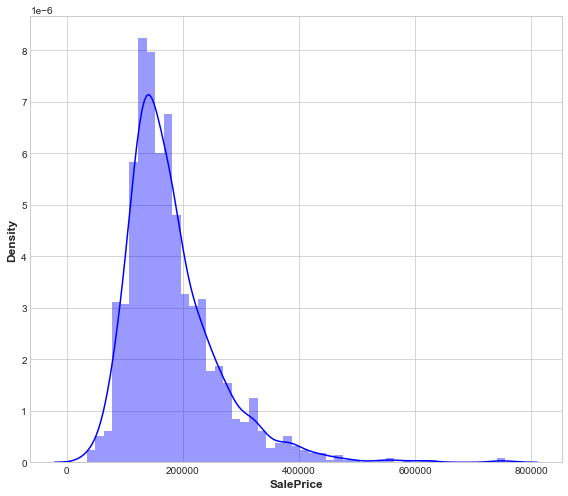

In [13]:
#SalePrice distribution
plt.figure(figsize = (8,7))
dist = sns.distplot(train['SalePrice'],color = 'blue',kde = True)

plt.show()

The distribution figure shows that SalePrice is not normaly distributed and will require further standardize.

Now lets see the correlation with each data and the SalePrice

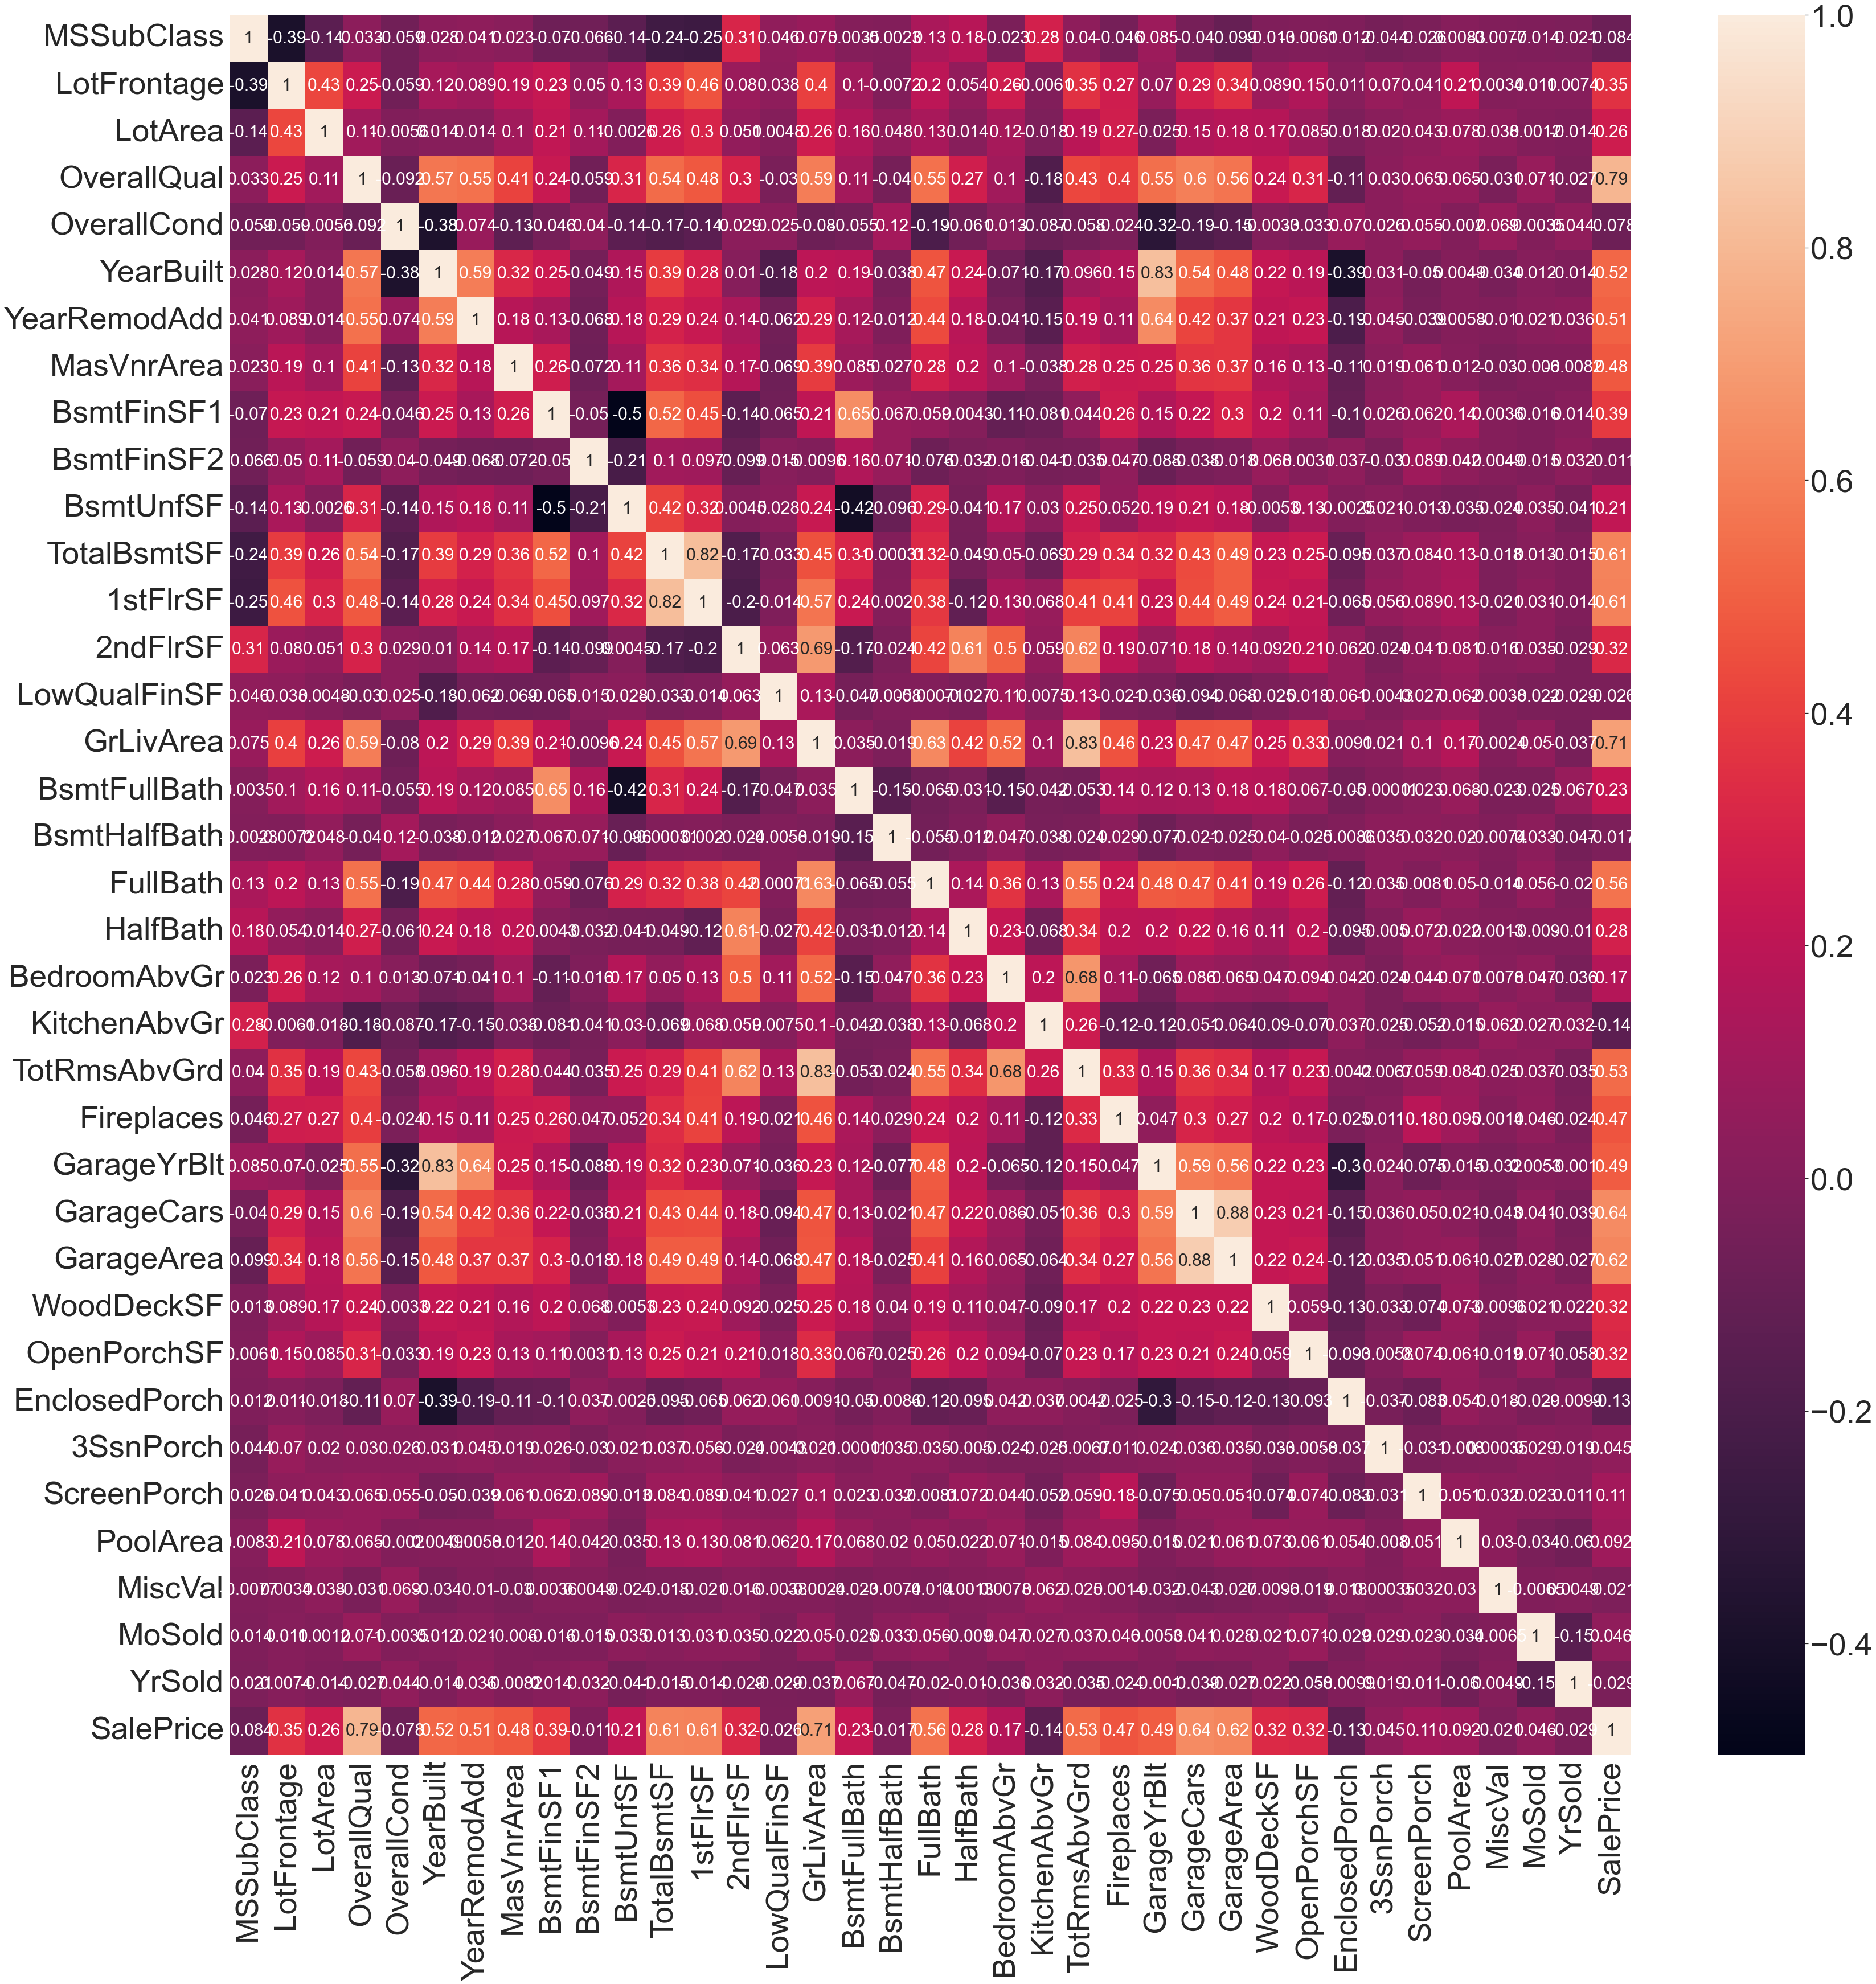

In [14]:
plt.figure(figsize = (50,50))

corr = train.corr()
sns.set(font_scale = 5)
sns.heatmap(corr,annot = True,annot_kws={"size": 30})
plt.show()


In [15]:
train.corr()['SalePrice'].sort_values(ascending=False)[1:11]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

10 Highest correlation with SalePrice:
1. OverallQual - 0.79 - Rates the overall material and finish of the house
2. GrLivArea - 0.71 - Above grade (ground) living area square feet
3. GarageCars - 0.64 - Size of garage in car capacity
4. GarageArea - 0.62 - Size of garage in square feet
5. Total BsmtSF  - 0.61 - Total square feet of basement area
6. 1stFlrSf - 0.61 - First Floor square feet
7. FullBath - 0.56 - Full bathrooms above grade
8. TotRmsAbvGrd - 0.53 - Total rooms above grade (does not include bathrooms)
9. YearBuild - 0.52 - Original construction date
10. YearRemodAdd - 0.51 - Remodel date (same as construction date if no remodeling or additions)

/In addition to above/
In the furher part of work, features like GarageCars & GarageArea that are highly correlated which each other,
will be careful examined in terms of feature engineering


Now lets plot those values in order to see if there are some obvious outliners

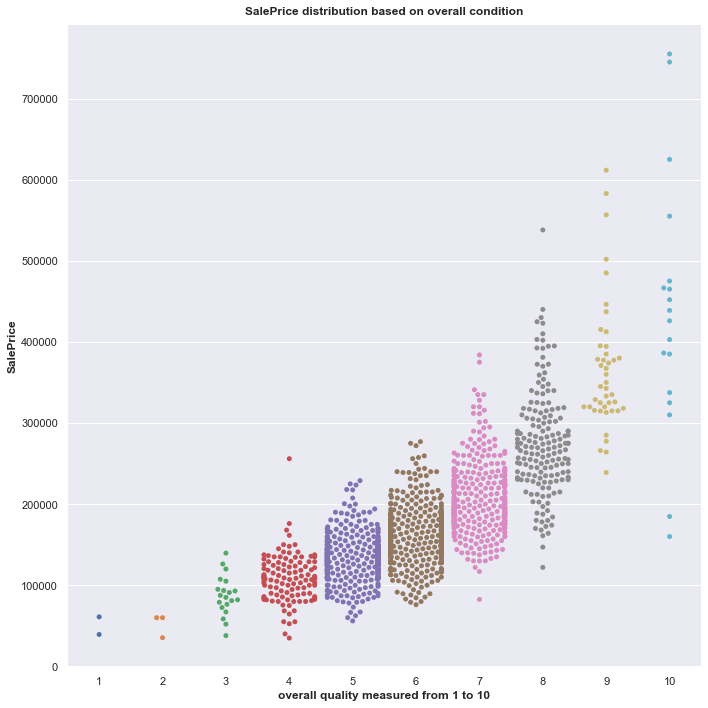

In [16]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
qual = sns.swarmplot(x = train['OverallQual'],y=train['SalePrice'])
qual.set(title = "SalePrice distribution based on overall condition",xlabel = 'overall quality measured from 1 to 10')
sns.despine()
plt.show()

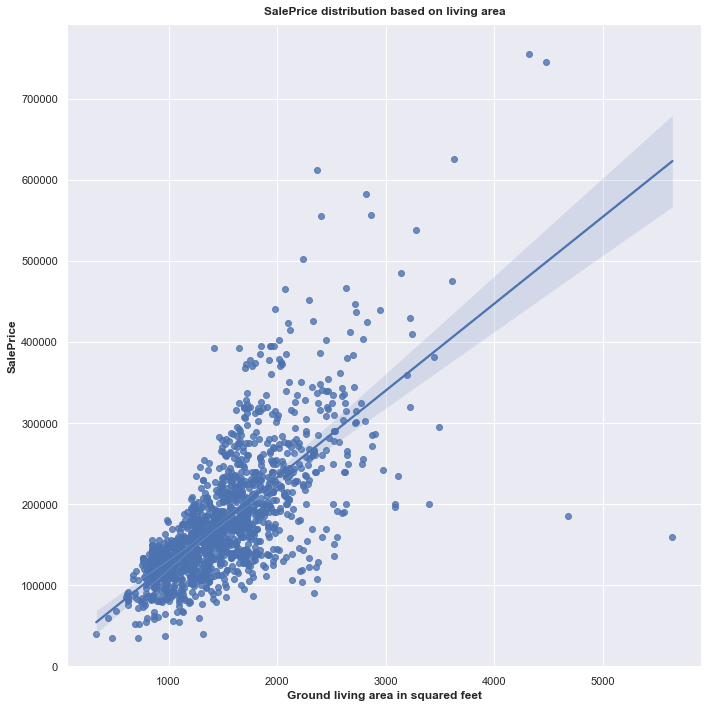

In [17]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
liv_area = sns.regplot(x = train['GrLivArea'], y = train['SalePrice'])
liv_area.set(title = 'SalePrice distribution based on living area',xlabel = 'Ground living area in squared feet')
sns.despine()
plt.show()

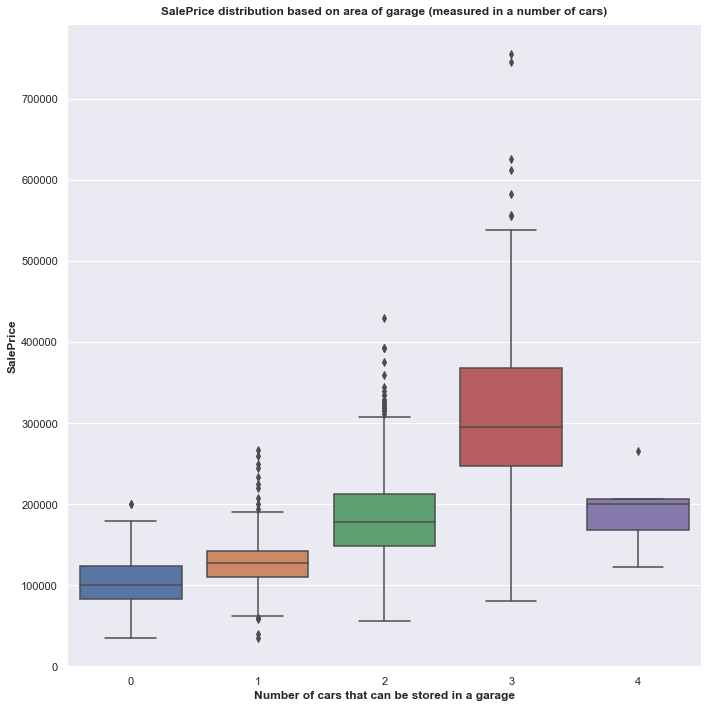

In [18]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
garage_cars = sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])
garage_cars.set(title = 'SalePrice distribution based on area of garage (measured in a number of cars)',xlabel = 'Number of cars that can be stored in a garage')
sns.despine()
plt.show()

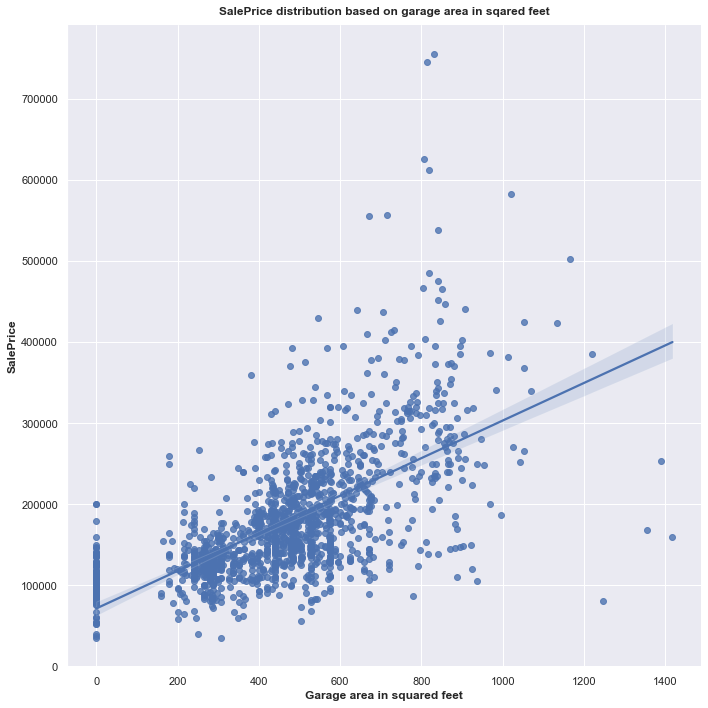

In [19]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
gar_area = sns.regplot(x = train['GarageArea'], y = train['SalePrice'])
gar_area.set(title = 'SalePrice distribution based on garage area in sqared feet',xlabel = 'Garage area in squared feet' )
sns.despine()
plt.show()

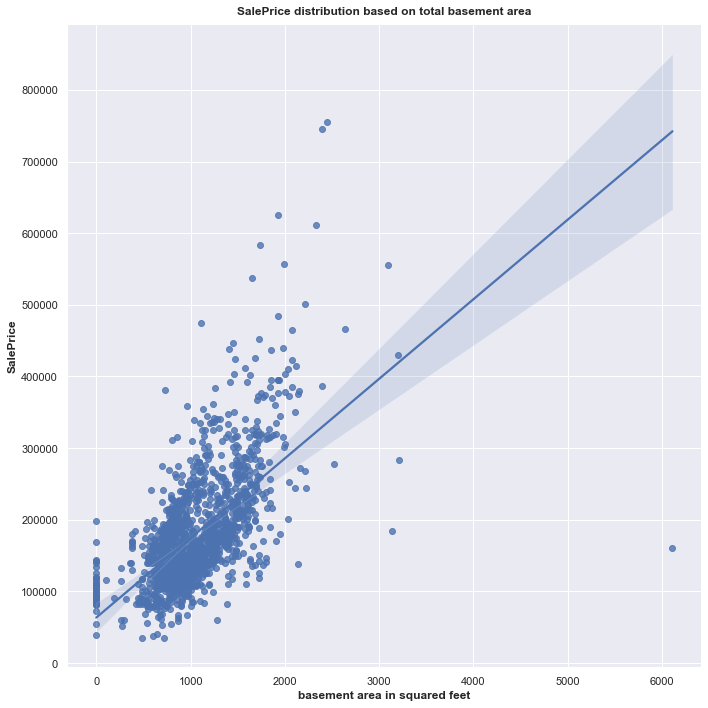

In [20]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
bsmt_area = sns.regplot(x = train['TotalBsmtSF'], y = train['SalePrice'])
bsmt_area.set(title = 'SalePrice distribution based on total basement area',xlabel = 'basement area in squared feet')
sns.despine()
plt.show()

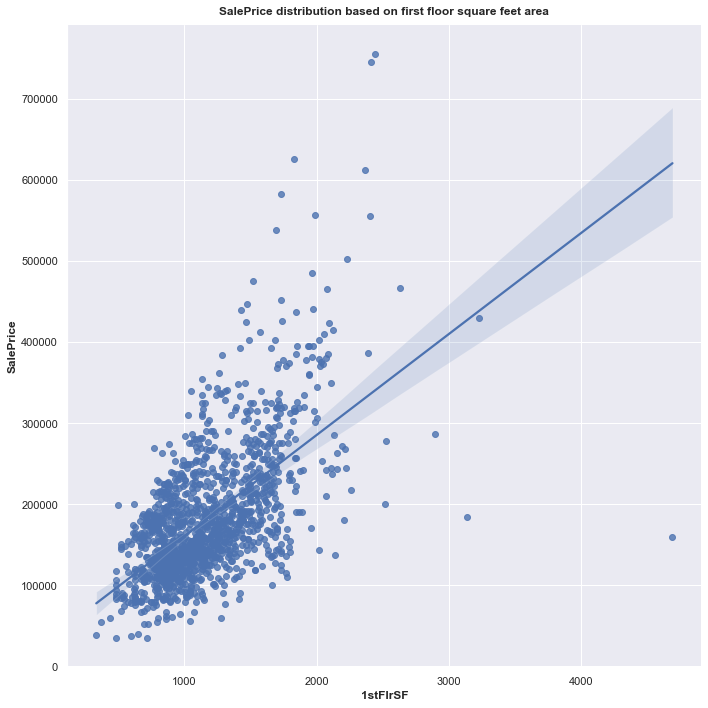

In [21]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
fst_area = sns.regplot(x = train['1stFlrSF'], y = train['SalePrice'])
fst_area.set(title = 'SalePrice distribution based on first floor square feet area')
sns.despine()
plt.show()

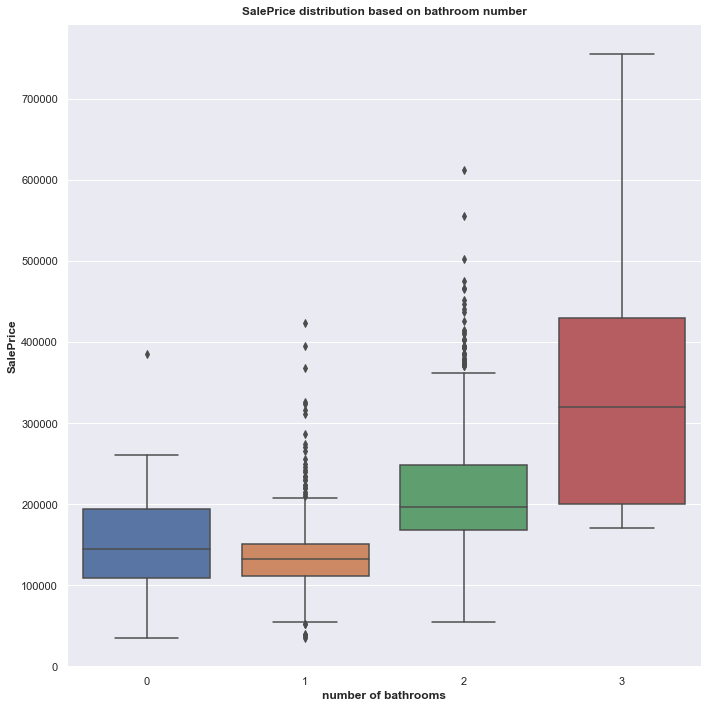

In [22]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
num_bath = sns.boxplot(x = train['FullBath'], y = train['SalePrice'])
num_bath.set(title = 'SalePrice distribution based on bathroom number',xlabel = 'number of bathrooms')
sns.despine()
plt.show()

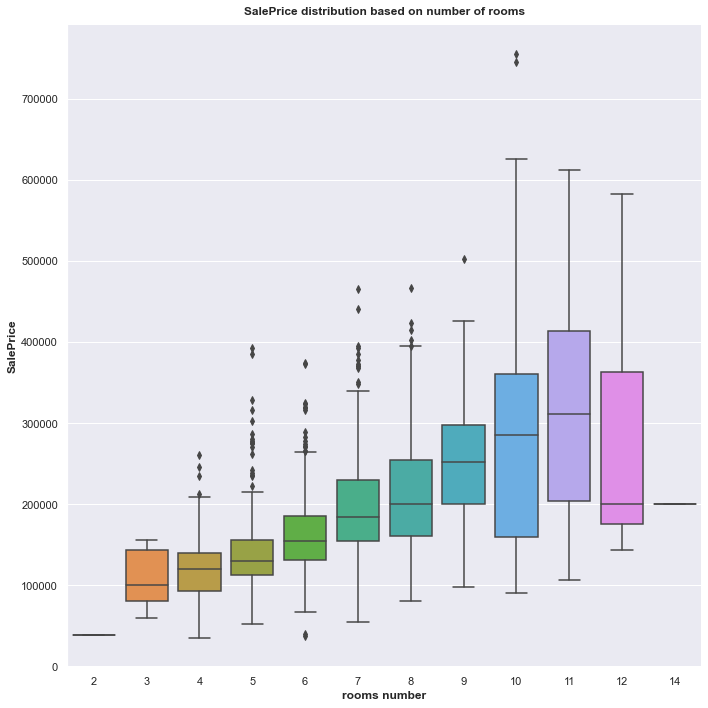

In [23]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
num_room = sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])
num_room.set(title = 'SalePrice distribution based on number of rooms',xlabel = 'rooms number')
sns.despine()
plt.show()

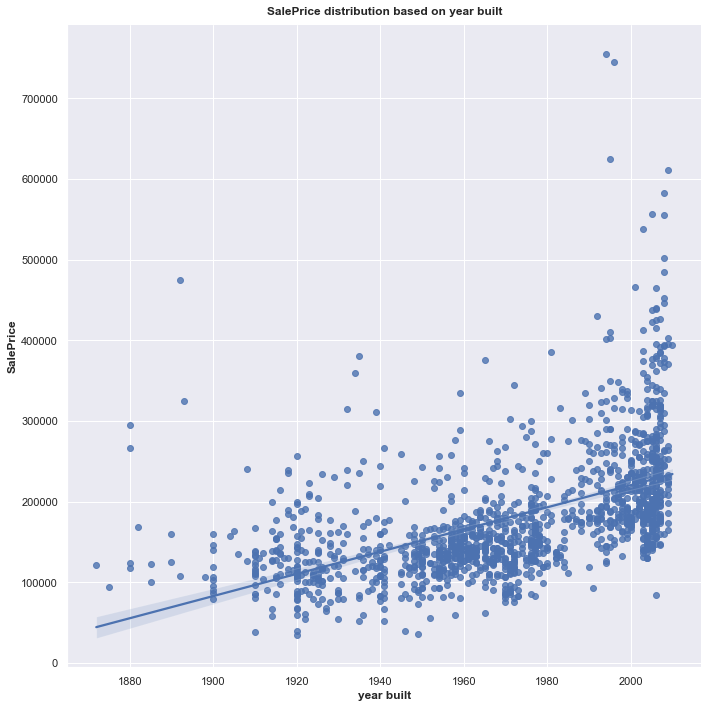

In [24]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
yr_built= sns.regplot(x = train['YearBuilt'], y = train['SalePrice'])
yr_built.set(title = 'SalePrice distribution based on year built',xlabel = 'year built')
sns.despine()
plt.show()

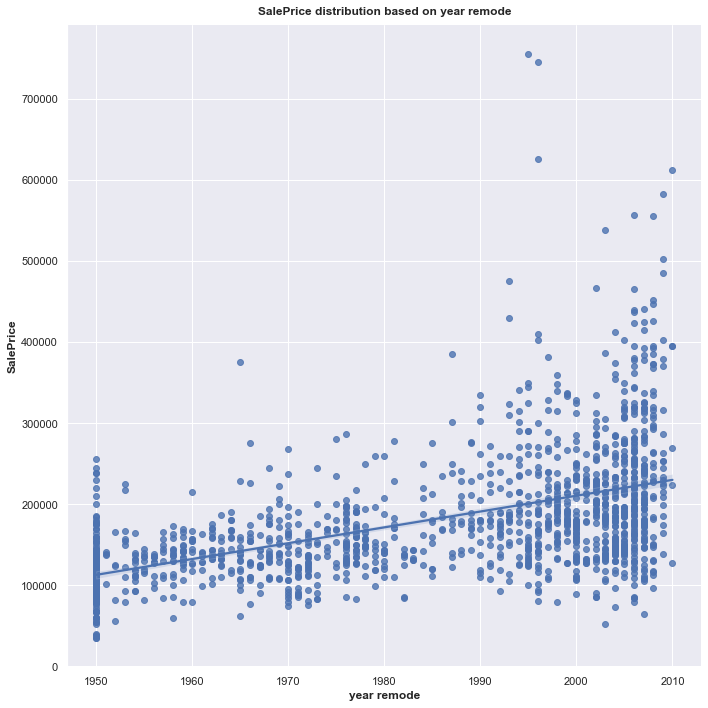

In [25]:
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
yr_remode= sns.regplot(x = train['YearRemodAdd'], y = train['SalePrice'])
yr_remode.set(title = 'SalePrice distribution based on year remode',xlabel = 'year remode')
sns.despine()
plt.show()

Lets investigate missing values

In [26]:
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending = False) #printing columns with missing values


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

First, lets consider those missing values which accualy are informative. According to data_description:
1. Nan in PoolQC means no pool
2. Nan in MiscFeatures means no miscellaneous feature
3. Nan in Alley means no alley acces
4. Nan in Fence means no fence
5. Nan in FireplaceQu means no fireplace

In [28]:
no_missing = train.copy()
no_missing.isnull().sum()[no_missing.isnull().sum()>0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [29]:
no_missing['PoolQC'] = no_missing['PoolQC'].fillna('None')
no_missing['MiscFeature'] = no_missing['MiscFeature'].fillna('None')
no_missing['Alley'] = no_missing['Alley'].fillna('None')
no_missing['Fence'] = no_missing['Fence'].fillna('None')
no_missing['FireplaceQu'] = no_missing['FireplaceQu'].fillna('None')

As we can see there are 81 missing values per garage's features which is connected with a non existance of a garage, 38 with a basement and 8 with a masonry veneer type

In [30]:
gar_cat_features = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
no_missing['GarageYrBlt'] =no_missing['GarageYrBlt'].astype(float) 
no_missing['GarageYrBlt'] = no_missing['GarageYrBlt'].fillna(0)
for fit in gar_cat_features:
    no_missing[fit] = no_missing[fit].fillna('None')

As far as Lot Frontage is considered, lets examine it's correlation to find out what would be the most suitale way of filling missing values

In [31]:
no_missing.corr()['LotFrontage'].sort_values(ascending = False)[1:5]
#It shows features that might be helpful in filling missing valuses, but lets also consider categorical feature: neighbrhood

1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
Name: LotFrontage, dtype: float64

In [33]:
no_missing.corr()['1stFlrSF'].sort_values(ascending = False)[1:5]

TotalBsmtSF    0.819530
SalePrice      0.605852
GrLivArea      0.566024
GarageArea     0.489782
Name: 1stFlrSF, dtype: float64

In [34]:
no_missing.corr()['GarageArea'].sort_values(ascending = False)[1:5]

GarageCars     0.882475
SalePrice      0.623431
OverallQual    0.562022
GarageYrBlt    0.560783
Name: GarageArea, dtype: float64

In [35]:
no_missing[['LotArea','LotFrontage','1stFlrSF','GrLivArea','Neighborhood']].sort_values(by = '1stFlrSF').head(20)
#while sorting by each of this features it appeared that the appropriate way is to fill missing values based on neighbor hood

LotArea  LotFrontage  1stFlrSF  GrLivArea Neighborhood
Id                                                          
534      5000         50.0       334        334      BrkSide
706      5600         70.0       372       1092       IDOTRR
1101     8400         60.0       438        438        SWISU
917      9000         50.0       480        480       IDOTRR
431      1680         21.0       483        987       BrDale
838      1680         21.0       483        987       BrDale
236      1680         21.0       483        987       BrDale
1379     1953         21.0       483        987       BrDale
233      1680         21.0       483        987       BrDale
228      1869         21.0       483        987       BrDale
364      1680         21.0       483        987       BrDale
363      7301         64.0       495       1922      Edwards
126      6780         60.0       520        754       IDOTRR
30       6324         60.0       520        520      BrkSide
832      3180         30.0       520       1200      Somerst
1365     3180         30.0       520       1200      Somerst
830      2544         24.0       520       1223      Somerst
656      1680         21.0       525       1092       BrDale
76       1596         21.0       526        988      MeadowV
345      2592         36.0       536       1112      MeadowV

In [36]:
#Filling LotFrontage values with a mean of LotFrontage in a particular neighborhoods
no_missing['LotFrontage'] = no_missing.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [37]:
#Lack of values in basement features means there is no basement so it will be filled with None
bsmt_features = ['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']
for feature in bsmt_features:
    no_missing[feature] = no_missing[feature].fillna("None")

In [38]:
#Lack of values in Masonry veneer features will be filled with "0" for area and "None" for type
no_missing['MasVnrType'] = no_missing['MasVnrType'].fillna('None')
no_missing['MasVnrArea'] = no_missing['MasVnrArea'].fillna(0)

In [39]:
#With the electrical column it will be used to filled with  a most common value
no_missing.groupby('Electrical').count()
no_missing['Electrical'] = no_missing['Electrical'].fillna('SBrkr')

In [40]:
no_missing.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

Having filled missing values the next step is feature engineering

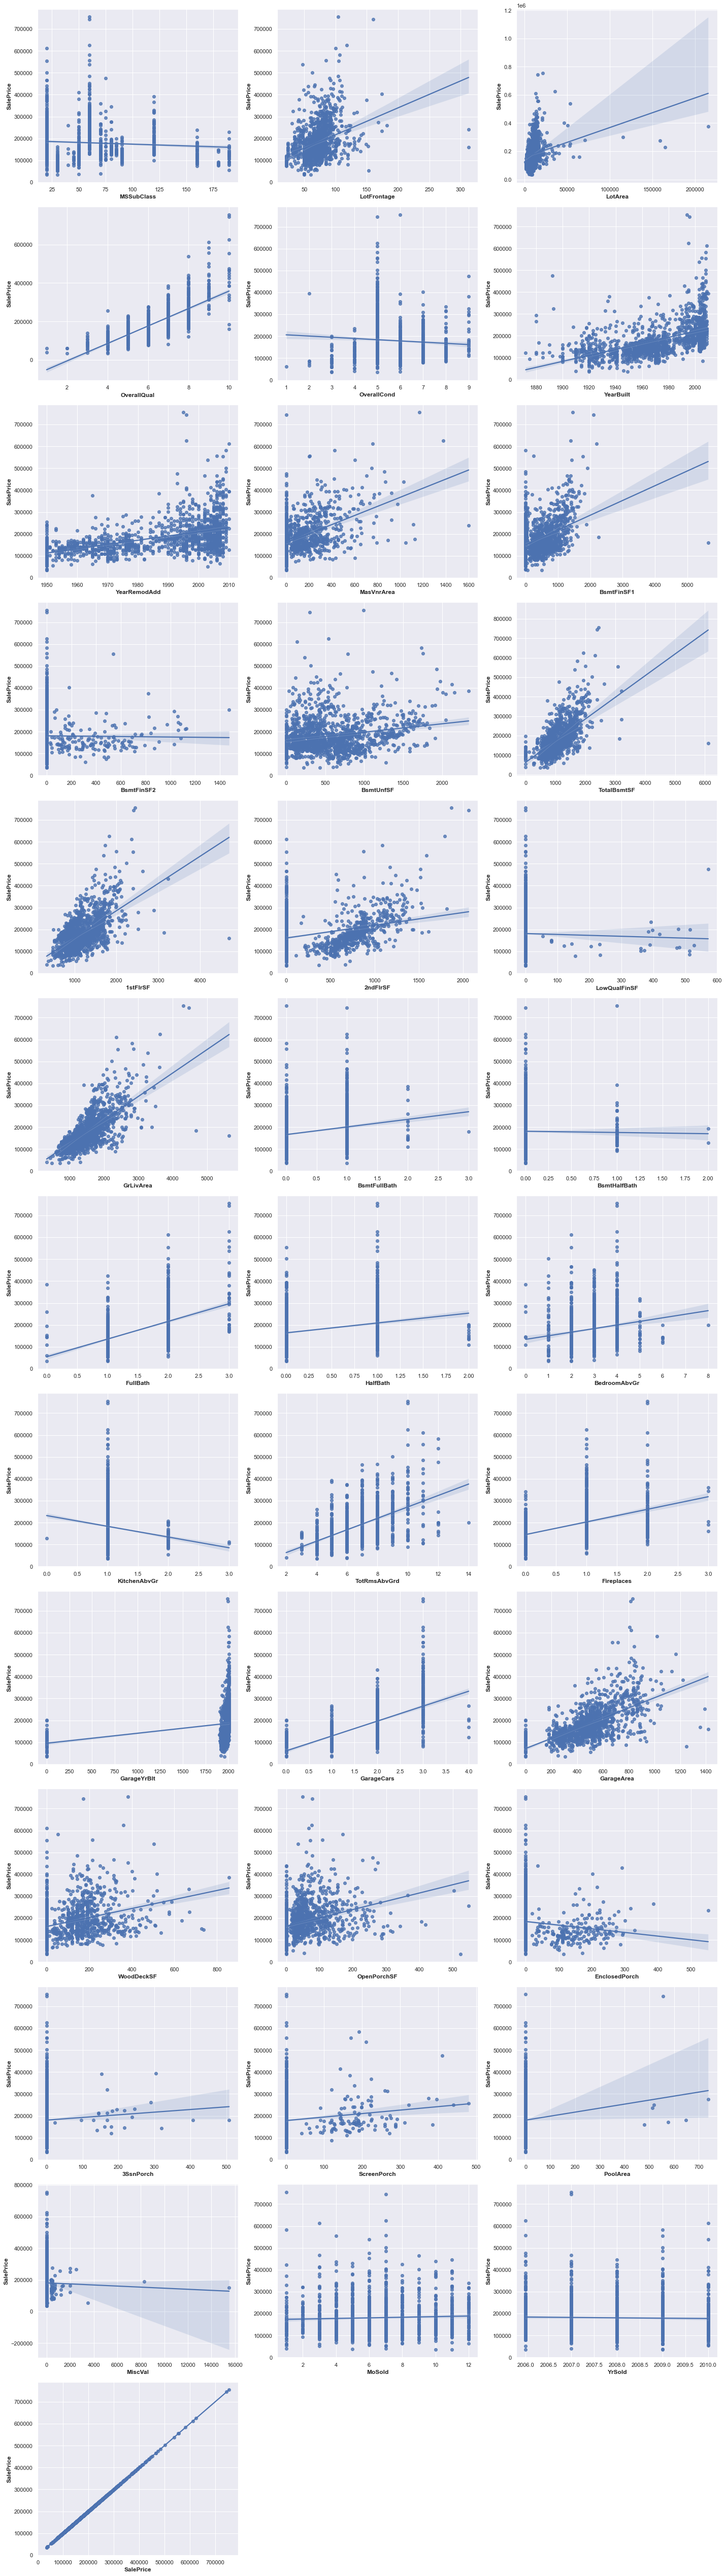

In [41]:
#Firstly lets remove outliars, to achieve this lets make a look on num variables again.
num_col = [col for col in no_missing.columns if no_missing[col].dtype != 'object'] #here are numerical columns
#now lets make a big suplot of those columns
fig, axs = plt.subplots(figsize=(20, 200)) #make a big figure for  subplots
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(num_col, 1):
    plt.subplot(len(num_col), 3, i)
    regs = sns.regplot(x=no_missing[feature], y=no_missing['SalePrice'])      
        
plt.show()

As we can see there are some outliers:
1. LotFrontage > 300 & SalePrice < 300000
2. BsmnFinSF1 > 5000 & SalePrice < 200000
3. TotalBsmtSF > 6000 & SalePrice < 200000
4. GrLivArea > 4000 & SalePrice <20000

In [42]:
no_missing = no_missing.drop(no_missing[(no_missing['GrLivArea']>4000) & (train['SalePrice']<200000)].index)
no_missing = no_missing.drop(no_missing[(no_missing['LotFrontage']>300) & (no_missing['SalePrice']<300000)].index)

The second important thing that comes with regplots is the fact that MoSold and YrSold doesnt have an impact on SalePrice so those features should be deleted

In [43]:
no_missing = no_missing.drop(['MoSold','YrSold'],axis = 1)
num_col.remove('YrSold')
num_col.remove('MoSold')

In [44]:
X = no_missing.copy()
y = X.SalePrice
X = X.drop(['SalePrice'],axis = 1)

In [45]:
num_col.remove('SalePrice')

In [46]:
discrete_features = X[num_col].dtypes == int

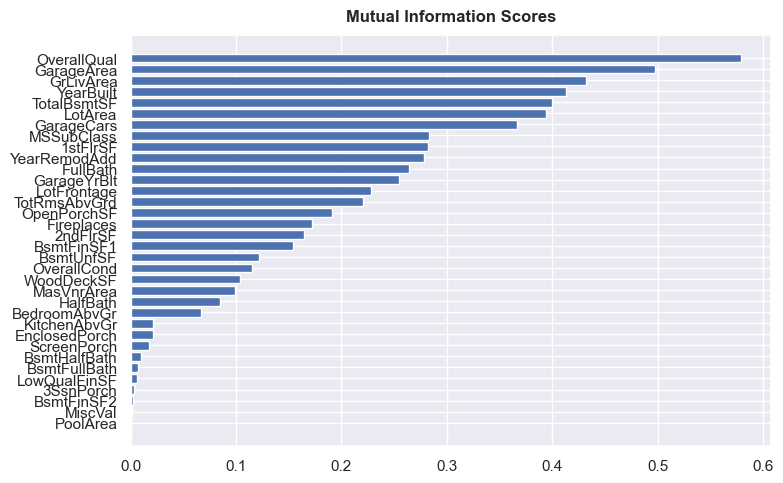

In [47]:
def mi_scores(x,y,discrete_features):
  mi_score = mutual_info_regression(x,y,discrete_features = discrete_features)
  mi_score = pd.Series(mi_score,name = 'MI scores',index = x.columns)
  mi_score = mi_score.sort_values(ascending = False)
  return mi_score

mi_scores(X[num_col],y,discrete_features)
#teraz czas na splotowanie wykresu dla lepszej analizy
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores(X[num_col],y,discrete_features))

Looking for outliar using PCA method

Standardize distribution of numerical variables

In [48]:
#making a list of a categorical data columns
cat_col = [col for col in X.columns if X[col].dtype == 'object']
rep_col = []
for i, col in enumerate(X.columns, 1): #check wheter there are no repetitions
    if col in cat_col and col in num_col:
        rep_col.append(col)
    else:
        rep_col.append(i)
print(rep_col)   


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


In [49]:
#lets devide categorical that suit for LabelEncodin (connected with quality) and OGetting dummies
OneHotEnc = []
LabelEnc = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
           'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','Fence',]
for col in cat_col:
    if col not in LabelEnc:
        OneHotEnc.append(col)
#Now we can encode columns with a chosen methods
#LabelEncoding --> for those features that comes with an intuition of ordering by numbers eq. quality: good-ok-bad
label_encoding = X[LabelEnc].copy()
for colname in label_encoding[LabelEnc]:
    label_encoding[colname], _ = label_encoding[colname].factorize()
#Getting dummies
dummy = X[OneHotEnc].copy()
dummy = pd.get_dummies(dummy[OneHotEnc])
#joining dummies + label encoding + numerical features
numerical = X.copy()
num = numerical[num_col]
train_encoded = pd.concat([num,label_encoding,dummy],axis = 1)
train_encoded.dropna(axis = 0, inplace = True)
train_encoded



MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
Id                                                      ...                   
1             2003       196.0         706           0  ...               0   
2             1976         0.0         978           0  ...               0   
3             2002       162.0         486           0  ...               0   
4             1970         0.0         216           0  ...               0   
5             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1456          2000         0.0           0           0  ...               0   
1457          1988       119.0         790         163  ...               0   
1458          2006         0.0         275           0  ...               0   
1459          1996         0.0          49        1029  ...               0   
1460          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      1   
5                0             0            1                      0   
...            ...           ...          ...                    ...   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   
1460             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
5                         0                     0                     0   
...                     ...                   ...                   ...   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   
1460                      0                     0                     0   

      SaleCondition_Normal  SaleCondi

In [51]:
x = train_encoded.copy()



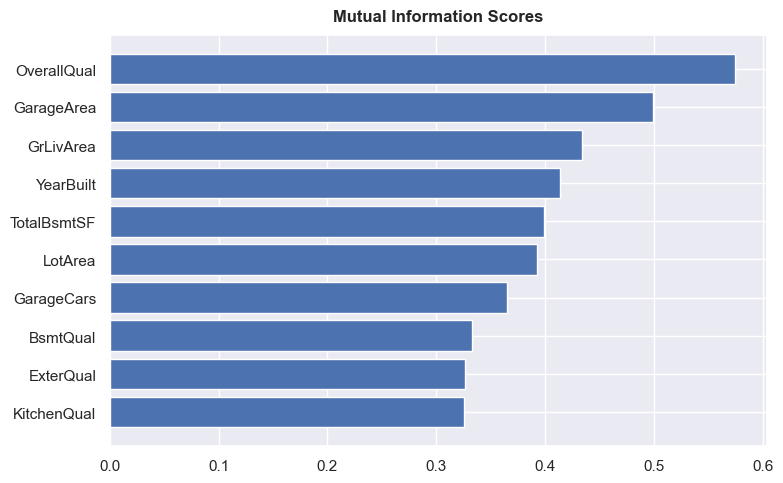

In [53]:
#Lets take a look on a cleared and encoded data in order to find some new correlation
discrete_features_all = x.dtypes == int
def mi_scores(x,y,discrete_features):
  mi_score = mutual_info_regression(x,y,discrete_features = discrete_features)
  mi_score = pd.Series(mi_score,name = 'MI scores',index = x.columns)
  mi_score = mi_score.sort_values(ascending = False)
  return mi_score


#For visualisation we can plot 10 best correlations
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores(x,y,discrete_features_all)[:10])

In [54]:
mi_scores(x,y,discrete_features_all)[:10]

OverallQual    0.587883
GarageArea     0.495934
GrLivArea      0.430466
YearBuilt      0.414359
TotalBsmtSF    0.402507
LotArea        0.394733
GarageCars     0.371148
KitchenQual    0.334211
ExterQual      0.333964
BsmtQual       0.327274
Name: MI scores, dtype: float64

In [55]:
#now lets investigate data using PCA
pca_train = x.copy()
#outliers = [313, 249, 335, 705, 451, 457, 384, 1393, 847, 768]
#pca_train = pca_train.drop(pca_train.index[outliers])
#y = y.drop(y.index[outliers])
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names,index = list(X.index.values))#included index list 
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [56]:
#lets use best ratings from mutual information to check PCA
mi_features = ['OverallQual','GarageArea','GrLivArea','YearBuilt','TotalBsmtSF','LotArea','GarageCars','KitchenQual',
               'BsmtQual','ExterQual']
pca_train = pca_train.loc[:,mi_features]


pca, X_pca, loadings = apply_pca(pca_train)
print(loadings)

                  PC1       PC2       PC3       PC4       PC5       PC6  \
OverallQual -0.407384  0.086908 -0.098358 -0.127720 -0.343778 -0.144245   
GarageArea  -0.397062  0.231971 -0.224185  0.195593  0.356064  0.227471   
GrLivArea   -0.308363  0.292707  0.145142  0.169511 -0.649845  0.334209   
YearBuilt   -0.362092 -0.208654 -0.170732 -0.298683  0.280834 -0.260429   
TotalBsmtSF -0.325495  0.217472  0.140750 -0.478754 -0.068271 -0.401462   
LotArea     -0.104180  0.280313  0.834440  0.170709  0.320786 -0.137021   
GarageCars  -0.415067  0.178442 -0.221577  0.189358  0.321959  0.247077   
KitchenQual  0.217164  0.493379 -0.129641 -0.477398 -0.011024  0.042631   
BsmtQual     0.183864  0.468585 -0.322200  0.484680 -0.040239 -0.613661   
ExterQual    0.283081  0.434416 -0.063511 -0.265441  0.202253  0.358527   

                  PC7       PC8       PC9      PC10  
OverallQual  0.206997  0.321322  0.716795 -0.040225  
GarageArea  -0.096317 -0.209547  0.050291 -0.682477  
GrLivArea   

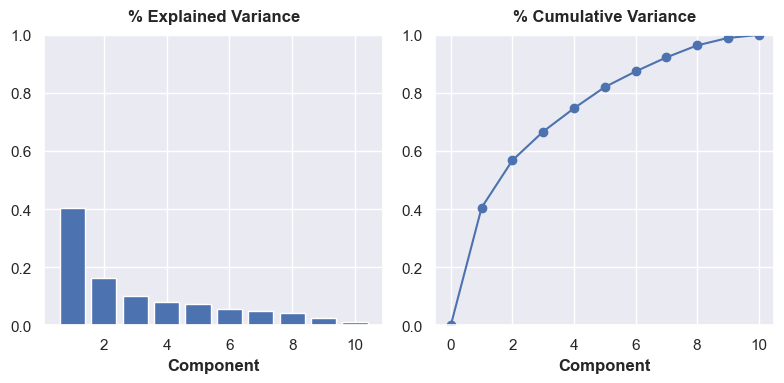

In [57]:
plot_variance(pca)
plt.show()

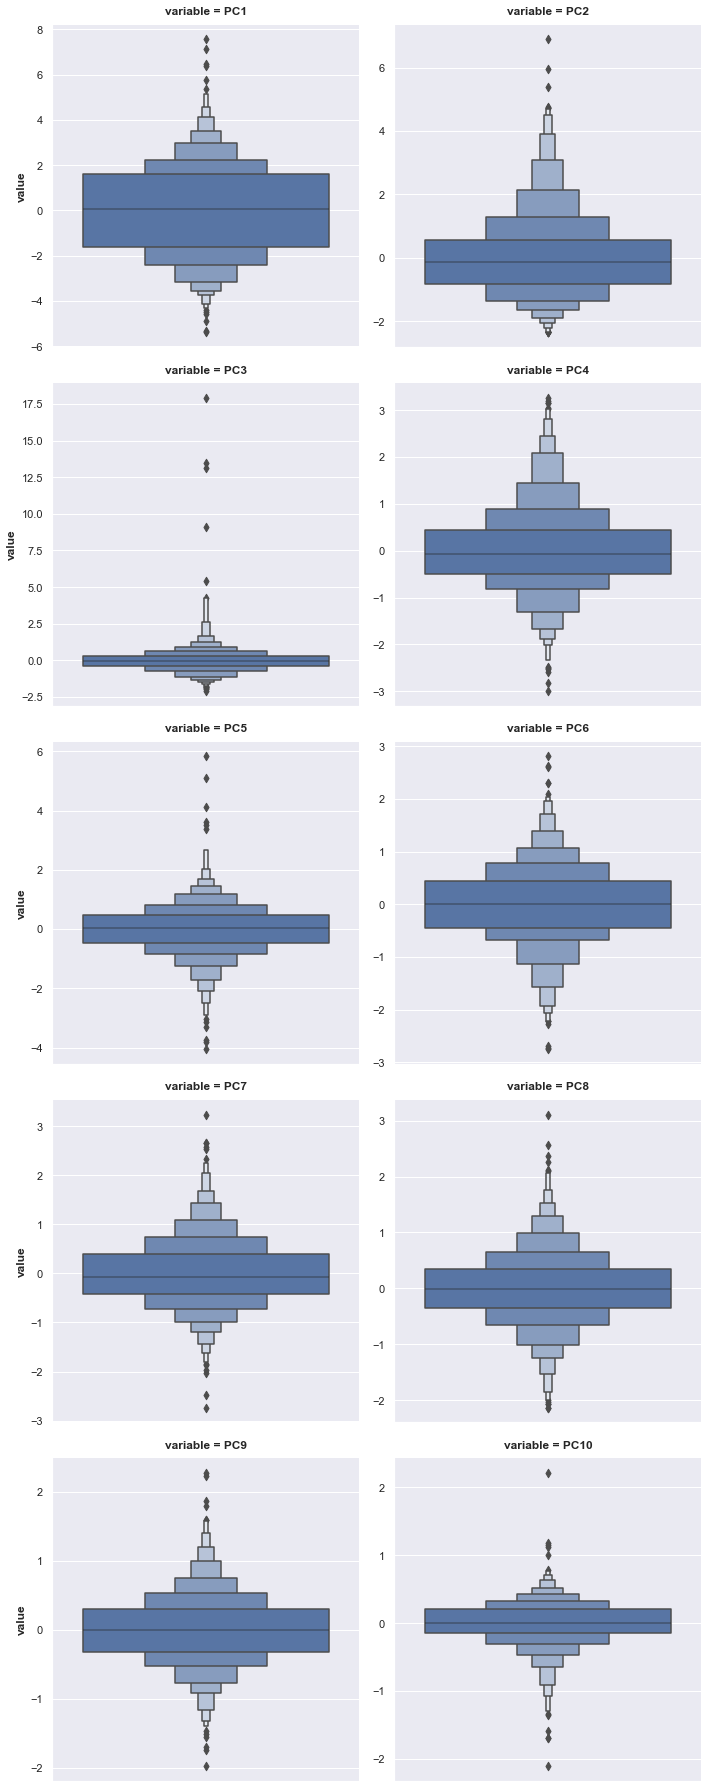

In [58]:
#PCA is a great tool to find outliars, first lets plot the distributions of the components
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [59]:
#As we can see there are some outliers in every variable so lets note down thier index value

component = "PC1"# name of the component
idx = X_pca[component].sort_values(ascending=False).index
#print(idx[:10])
pca_train.loc[idx[:10], mi_features] #dataframe of chosen indexes
id_pc1 = [532,375,635,704,1320,1180,1167]
id_pc2 = [313,690,335,440]
id_pc3 = [313,249,335,705,451]
id_pc5 = [313,335,1059,249,1188,1180,1346,634]
id_pc6 = [1059,1255,313]
id_pc7 = [313,332,496]
id_pc9 = [582,989]
id_pc10 = [1337,643,268,580]
outliers_id = []
id_list = [id_pc1,id_pc2,id_pc3,id_pc5,id_pc6,id_pc7,id_pc9,id_pc10]
for lst in id_list: #loop that check reapeting indexes and making a final outliers_id list
    for i in lst:
        if i not in outliers_id:
            outliers_id.append(i)
print(outliers_id)


[532, 375, 635, 704, 1320, 1180, 1167, 313, 690, 335, 440, 249, 705, 451, 1059, 1188, 1346, 634, 1255, 332, 496, 582, 989, 1337, 643, 268, 580]


In [60]:
X_pca['PC2'].sort_values(ascending = False)

314     6.892480
692     5.954503
336     5.398632
441     4.746783
179     4.723084
          ...   
812    -2.356513
1079   -2.356598
1442   -2.356854
691    -2.356854
722    -2.356854
Name: PC2, Length: 1457, dtype: float64

In [62]:
# droping outliers
cleared_pca = x.join(X_pca)
cleared_pca = cleared_pca.drop(cleared_pca.index[outliers_id])

In [63]:
cleared_pca

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...       PC1  \
Id                                                      ...             
1             2003       196.0         706           0  ... -1.606501   
2             1976         0.0         978           0  ... -0.079257   
3             2002       162.0         486           0  ... -1.820695   
4             1970         0.0         216           0  ... -0.517607   
5             2000       350.0         655           0  ... -3.544927   
...            ...         ...         ...         ...  ...       ...   
1456          2000         0.0           0           0  ... -0.328585   
1457          1988       119.0         790         163  ... -0.927928   
1458          2006         0.0         275           0  ...  0.821036   
1459          1996         0.0          49        1029  ...  1.650901   
1460          1965         0.0         830         290  ...  0.967895   

           PC2       PC3       PC4       PC5       PC6       PC7       PC8  \
Id                                                                           
1    -1.531445 -0.075290  0.379902 -0.197775  0.191044  0.593744  0.211951   
2    -0.059647  0.054191 -1.079312  0.534352  0.416496 -0.228373 -0.136914   
3    -1.295061  0.153236  0.454997 -0.132360  0.221728  0.522723  0.127989   
4     0.690678 -0.388983  1.814315 -0.077192  1.395709 -0.888949 -0.061088   
5    -0.296109 -0.000797  0.765607 -0.044414  0.712045  0.361500 -0.083350   
...        ...       ...       ...       ...       ...       ...       ...   
1456 -0.206468 -0.213147 -0.850901  0.251601  0.793907  0.497535  0.446314   
1457  0.686142  0.630195 -1.052654 -0.347409  0.655201 -0.449025 -0.113914   
1458  0.917256  0.627415 -0.029571 -1.877261  0.751699 -1.494512  2.038822   
1459 -0.788940  0.514265  0.194729 -0.017979 -0.522834 -1.148009  0.433518   
1460 -0.709195  0.448294 -0.276540 -0.436415 -1.236614  0.129924 -1.088320   

           PC9      PC10  
Id                        
1    -0.083670 -0.171134  
2     0.166172  0.285837  
3    -0.103957 -0.355141  
4     1.376969  0.681188  
5     0.137280 -0.131641  
...        ...       ...  
1456 -0.490242  0.182652  
1457 -0.651375  0.158811  
1458  0.123797  0.003208  
1459  0.060675  0.109300  
1460 -0.469539 -0.036440  

[1430 rows x 249 columns]

In [64]:
pca_y = no_missing['SalePrice']
pca_y = pca_y.drop(pca_y.index[outliers_id])
pca_y
#At this point there is new data set --> cleared_pca and target data--> pca_y

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1430, dtype: int64

In [65]:
#Check whether removing outliers comes with better data distribution
CLEAR = cleared_pca.copy()
CLEARED= CLEAR.loc[:,mi_features]

pca, X_pca, loadings = apply_pca(CLEARED)
print(loadings)

                  PC1       PC2       PC3       PC4       PC5       PC6  \
OverallQual -0.404913  0.047750 -0.128951 -0.108342 -0.426020  0.023709   
GarageArea  -0.401015  0.216169 -0.276229  0.160073  0.338040 -0.166555   
GrLivArea   -0.313421  0.278580  0.262446  0.229833 -0.591753 -0.333759   
YearBuilt   -0.359462 -0.239098 -0.231889 -0.274705  0.178324  0.093498   
TotalBsmtSF -0.320235  0.179791  0.098329 -0.523646 -0.063470  0.557986   
LotArea     -0.153760  0.387745  0.709386  0.094486  0.393550  0.136269   
GarageCars  -0.415054  0.163906 -0.274295  0.163935  0.299700 -0.236213   
KitchenQual  0.204610  0.475311 -0.178696 -0.476877 -0.148325 -0.196278   
BsmtQual     0.175750  0.454578 -0.387867  0.469637 -0.106935  0.572894   
ExterQual    0.276716  0.417276 -0.117947 -0.276360  0.200249 -0.314823   

                  PC7       PC8       PC9      PC10  
OverallQual  0.086153  0.347215 -0.702528  0.042631  
GarageArea  -0.072711 -0.260619 -0.034713  0.688554  
GrLivArea   

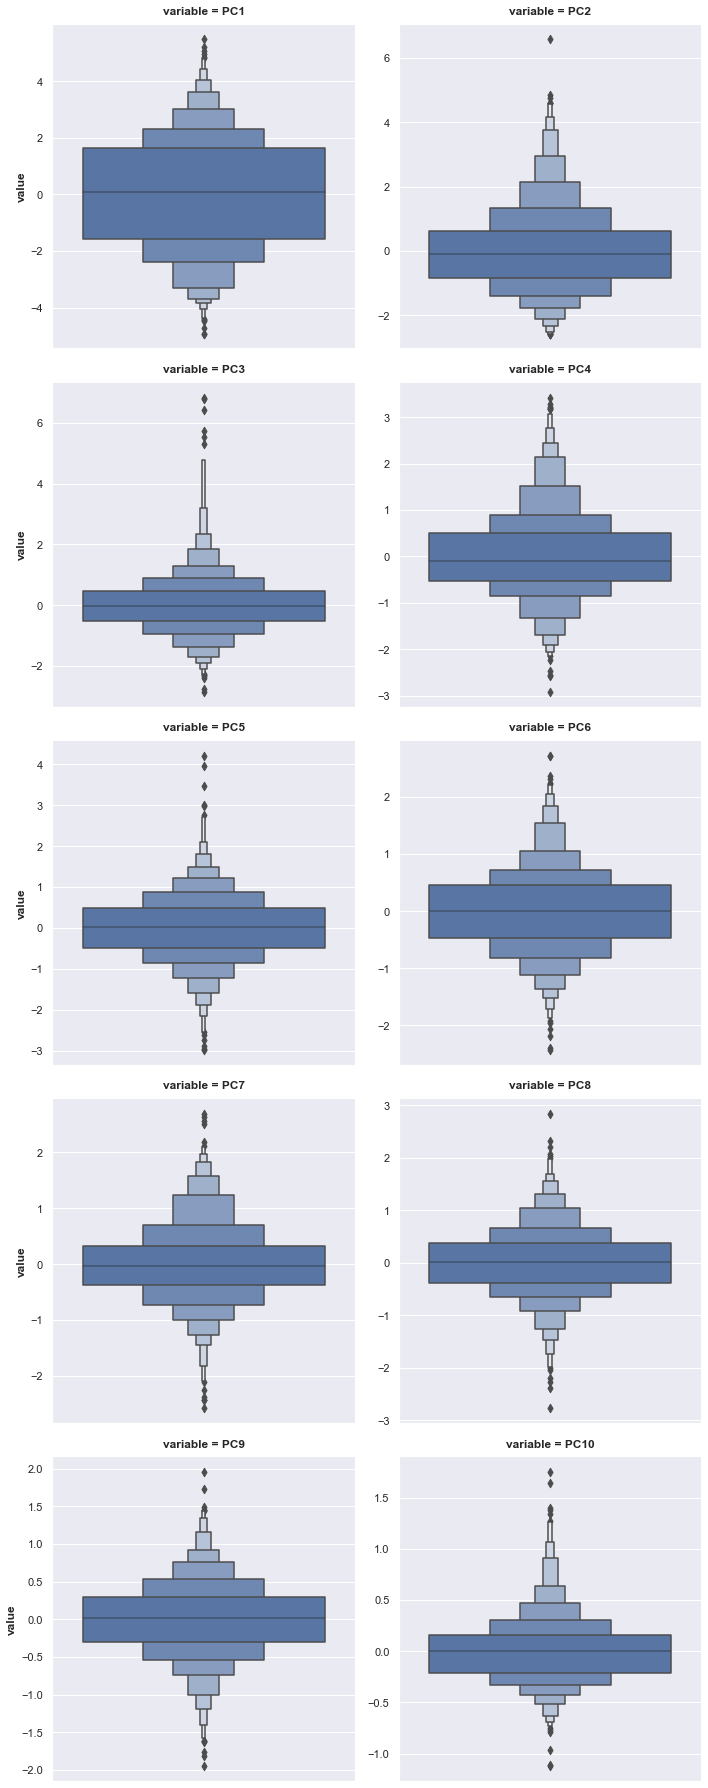

In [66]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

After making features with MI and PCA lets figure out some new interesting features manually

In [68]:
TRAIN = cleared_pca.copy()

In [69]:
TRAIN['WholeArea']=TRAIN['LotArea'] + TRAIN['GrLivArea'] + TRAIN['GarageArea'] + TRAIN['TotalBsmtSF']
TRAIN['TotBath'] = TRAIN['BsmtFullBath'] + TRAIN['FullBath']
TRAIN['YrSincRemod'] = TRAIN['YearRemodAdd'] - TRAIN['YearBuilt']
TRAIN

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1             60         65.0     8450            7            5       2003   
2             20         80.0     9600            6            8       1976   
3             60         68.0    11250            7            5       2001   
4             70         60.0     9550            7            5       1915   
5             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...       PC4  \
Id                                                      ...             
1             2003       196.0         706           0  ...  0.379902   
2             1976         0.0         978           0  ... -1.079312   
3             2002       162.0         486           0  ...  0.454997   
4             1970         0.0         216           0  ...  1.814315   
5             2000       350.0         655           0  ...  0.765607   
...            ...         ...         ...         ...  ...       ...   
1456          2000         0.0           0           0  ... -0.850901   
1457          1988       119.0         790         163  ... -1.052654   
1458          2006         0.0         275           0  ... -0.029571   
1459          1996         0.0          49        1029  ...  0.194729   
1460          1965         0.0         830         290  ... -0.276540   

           PC5       PC6       PC7       PC8       PC9      PC10  WholeArea  \
Id                                                                            
1    -0.197775  0.191044  0.593744  0.211951 -0.083670 -0.171134      11564   
2     0.534352  0.416496 -0.228373 -0.136914  0.166172  0.285837      12584   
3    -0.132360  0.221728  0.522723  0.127989 -0.103957 -0.355141      14564   
4    -0.077192  1.395709 -0.888949 -0.061088  1.376969  0.681188      12665   
5    -0.044414  0.712045  0.361500 -0.083350  0.137280 -0.131641      18439   
...        ...       ...       ...       ...       ...       ...        ...   
1456  0.251601  0.793907  0.497535  0.446314 -0.490242  0.182652      10977   
1457 -0.347409  0.655201 -0.449025 -0.113914 -0.651375  0.158811      17290   
1458 -1.877261  0.751699 -1.494512  2.038822  0.123797  0.003208      12786   
1459 -0.017979 -0.522834 -1.148009  0.433518  0.060675  0.109300      12113   
1460 -0.436415 -1.236614  0.129924 -1.088320 -0.469539 -0.036440      12725   

      TotBath  YrSincRemod  
Id                          
1           3            0  
2           2            0  
3           3            1  
4           2           55  
5           3            0  
...       ...          ...  
1456        2            1  
1457        3           10  
1458        2           65  
1459        2           46  
1460        2            0  

[1430 rows x 252 columns]

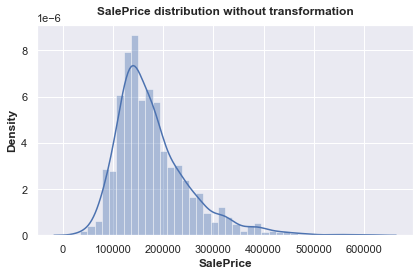

In [71]:
#Final data preprocessing
#lets plot again a saleprice dist
ax = sns.distplot(pca_y)
ax.set(title = 'SalePrice distribution without transformation')
plt.show()

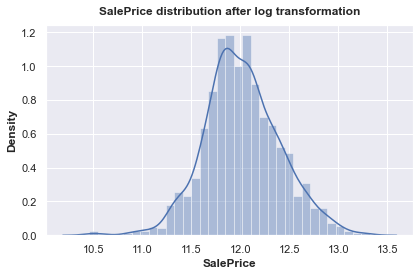

In [72]:
# The SalePrice is not normally distributed so in order to fix that it will be transformed using log(1+x)
pca_y = np.log(pca_y)
new = sns.distplot(pca_y)
new.set(title = 'SalePrice distribution after log transformation')
plt.show()#Now it seems to be normally distributed

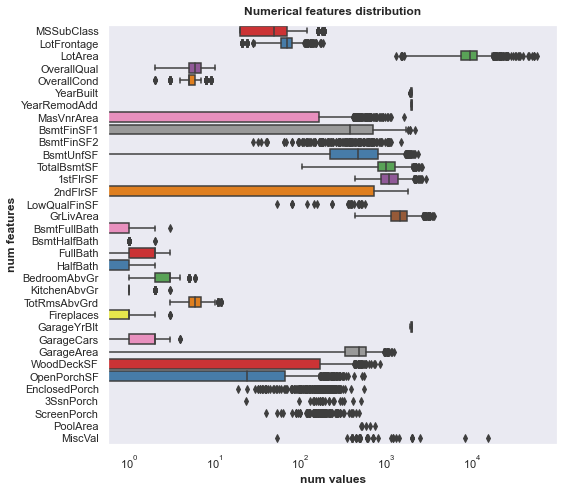

In [73]:
#Looking for skewness in TRAIN data
norm_train = TRAIN.copy()
#boxplot of  numerical features dist
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=norm_train[num_col] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(title = 'Numerical features distribution',xlabel = 'num values',ylabel = 'num features')
plt.show()

In [74]:
skew_features = norm_train[num_col].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          25.337075
PoolArea         17.346021
3SsnPorch        10.184571
LowQualFinSF      9.290116
KitchenAbvGr      4.511562
BsmtFinSF2        4.293906
BsmtHalfBath      4.113881
ScreenPorch       4.092245
LotArea           3.506396
EnclosedPorch     3.058267
dtype: float64

In [75]:
# Normalize skewed features
for i in skew_index:
    norm_train[i] = boxcox1p(norm_train[i], boxcox_normmax(norm_train[i] + 1))

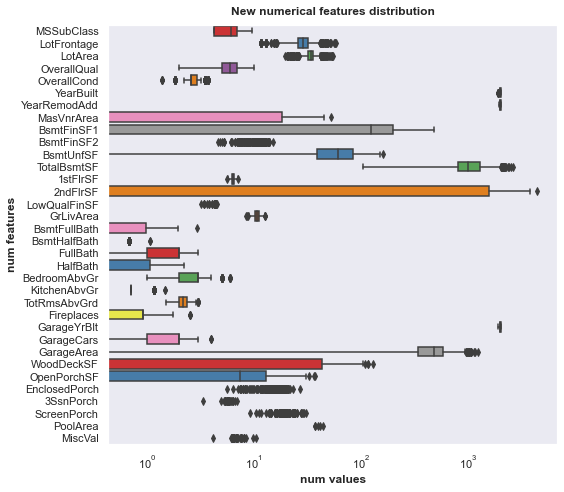

In [76]:
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=norm_train[num_col] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(title = 'New numerical features distribution',xlabel = 'num values',ylabel = 'num features')
plt.show()

When we got our data preprocessed it's time for modeling. Models that are gonna be used:
1. RandomForestRegressor
2. XGBRegressor
3. GradientBoostingRegressor
4. Ridge Regression
5. SupportVectorMachine

Preparing Data For Linear Regression

In [88]:
# Slice dataset for further evaluation on training and testing sets
X_train, X_test, y_train, y_test = train_test_split(norm_train,pca_y,train_size = 0.8, test_size = 0.2, random_state = 0)
# Prepare data for models to see which transformation is most suitable for this problem

# Raw data
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

# Normalize
norm_pip = Pipeline([
    ('normalization', MinMaxScaler())])
X_train_norm = norm_pip.fit_transform(X_train)
X_test_norm = norm_pip.transform(X_test)

# Standardize --> This transformation is done only on num_cols not to assign distribution to categorical features
stand_pip = Pipeline([('standardization',StandardScaler())])
X_train_std = stand_pip.fit_transform(X_train)
X_test_std = stand_pip.transform(X_test)

# RobustScaler -> deleting outliers
rob_pip = Pipeline([('robust',RobustScaler())])
X_train_rob = rob_pip.fit_transform(X_train)
X_test_rob = rob_pip.transform(X_test)

# Making a lists

xtrain = [X_train_raw,X_train_norm,X_train_std,X_train_rob]
xtest = [X_test_raw,X_test_norm,X_test_std,X_test_rob]

Building models list to do:
1. set up cross-validation
2. set up models
3. find best hyper-parameters using gridsearchcv
4. fit models with best params
5. evaluate metrics 
6. choose best model
7. make final predictions to 

Prepering metrics evaluation


In [77]:
# Despite cross validation, normal validation may be useful
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


In [80]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
#Defining cross value score
def cross_val(model):
    score = -1 * cross_val_score(model,norm_train,pca_y,cv = cv,scoring = 'neg_root_mean_squared_error',n_jobs = -1)#since cross val computes negative values
    #we need to times the result by -1
    return score.mean()

Looking for best hyper parameters using GridSearchCV

In [277]:
# ridge parameters

ridge = Ridge(max_iter = 100000,random_state=0)
ridge_par = {}
ridge_par['alpha'] = [10,10.05,11,11.5,12,13,14,15,16,17,18,19,20]
ridge_par['tol'] = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]

search = GridSearchCV(ridge, ridge_par, scoring='neg_root_mean_squared_error', cv=cv, n_jobs = -1)
results = search.fit(norm_train ,pca_y)
# summarize
print('RMSE: {}'.format(results.best_score_* - 1))
print('Config: {}'.format(results.best_params_))

RMSE: 0.1107309552227181
Config: {'alpha': 10, 'tol': 1e-15}


In [83]:
#Lasso model
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state = 0)
gbr_par = {}
gbr_par['n_estimators'] = [4500]
gbr_par['learning_rate'] = [1e-6,1e-5,1e-4]#,1e-3,0.01,0.1,1,10]
#gbr_par['loss'] = ['squared_error', 'absolute_error', 'huber', 'quantile']
gbr_par['max_depth'] = [6,10,15]
#gbr_par['min_samples_leaf'] = [5,10,15,20,25]
#gbr_par['min_samples_split'] = [5,10,15,20,25]

search = GridSearchCV(gbr,gbr_par,scoring = 'neg_root_mean_squared_error',cv=cv,n_jobs = -1)
results = search.fit(norm_train,pca_y)
# summarize
print('RMSE: {}'.format(results.best_score_* - 1))
print('Config: {}'.format(results.best_params_))

In [282]:
#Support Vector Machine model (support vector regressor)
svm_reg = SVR(kernel='rbf')
svm_par = {}
svm_par['C'] = [10000,20000,50000]
svm_par['epsilon'] = [1e-3,1e-2,1e-1]
search = GridSearchCV(svm_reg,svm_par,scoring = 'neg_root_mean_squared_error',cv=cv,n_jobs = -1)
results = search.fit(norm_train,pca_y)
# summarize
print('RMSE: {}'.format(results.best_score_* - 1))
print('Config: {}'.format(results.best_params_))

RMSE: 0.15667513804856575
Config: {'C': 20000, 'epsilon': 0.1}


In [283]:
#Random Forest regressor
r_forest = RandomForestRegressor(random_state=0)
r_par = {}
r_par['n_estimators'] = [1000,3000]
#r_par['max_features'] = ['auto', 'sqrt']
r_par['min_samples_leaf'] = 2
#r_par['min_samples_split'] = [2, 5, 10]
#r_par['max_depth'] = [5,10,15]
search = GridSearchCV(r_forest,r_par,scoring = 'neg_root_mean_squared_error',cv = cv,n_jobs = -1)
results = search.fit(norm_train,pca_y)
print('RMSE: {}'.format(results.best_score_* - 1))
print('Config: {}'.format(results.best_params_))

RMSE: 0.13159201122156242
Config: {'min_samples_leaf': 2, 'n_estimators': 1000}


In [286]:
#XGBRegressor
xgb = XGBRegressor(n_estimators = 2000, learning_rate = 0.01)
xgb_par = {}
#xgb_par['n_estimators'] = [500,2000,4000]
#xgb_par['learning_rate'] = [0.001,0.01,0.1]
xgb_par['max_depth'] = [2,4,6]
search = GridSearchCV(xgb,xgb_par,scoring = 'neg_root_mean_squared_error',cv = cv,n_jobs = -1)
result = search.fit(norm_train,pca_y)
print('RMSE: {}'.format(result.best_score_* -1))
print('Best configuration: {}'.format(result.best_params_))

RMSE: 0.11695897441668465
Best configuration: {'max_depth': 4}


In [285]:
print('RMSE: {}'.format(result.best_score_* -1))
print('Best configuration: {}'.format(result.best_params_))

RMSE: 0.1193775389344056
Best configuration: {'learning_rate': 0.01, 'n_estimators': 2000}


In [84]:
#fiting models with best hyper-parameters
ridge = Ridge(alpha = 10, tol = 1e-15, random_state = 0)
svm_reg = SVR(kernel='rbf',C=20000,epsilon = 0.01)
xgb = XGBRegressor(n_estimators = 2000, learning_rate = 0.01,max_depth = 4,random_state = 0)
r_forest = RandomForestRegressor(n_estimators = 1000,max_features = 'sqrt',min_samples_leaf = 2,max_depth = 10,random_state =0)
gbr= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',random_state = 0)

In [86]:
# evaluate cross score
models_score = {}
models = [ridge,svm_reg,xgb,r_forest,gbr]
for i in range(len(models)):
    models_score[str(models[i])+' RMSE:'] = cross_val(models[i])
print("Each model's RMSE: \n")
print(models_score)


Each model's RMSE: 

{'Ridge(alpha=10, random_state=0, tol=1e-15) RMSE:': 0.1107309552227181, 'SVR(C=20000, epsilon=0.01) RMSE:': 0.15770904643989705, 'XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n             colsample_bynode=None, colsample_bytree=None,\n             enable_categorical=False, gamma=None, gpu_id=None,\n             importance_type=None, interaction_constraints=None,\n             learning_rate=0.01, max_delta_step=None, max_depth=4,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=2000, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,\n             scale_pos_weight=None, subsample=None, tree_method=None,\n             validate_parameters=None, verbosity=None) RMSE:': 0.11695897441668465, "RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,\n                      n_estimators=1000, random_state=0) RMS

In [91]:
rmse = []

# raw, normalized, standardized and robusted training and testing data
xtrain = [X_train_raw,X_train_norm,X_train_std,X_train_rob]
xtest = [X_test_raw,X_test_norm,X_test_std,X_test_rob]

# model fitting and measuring RMSE
for i in range(len(xtrain)):
    
    # fit
    ridge.fit(xtrain[i],y_train)
    # predict
    pred = ridge.predict(xtest[i])
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

# visualizing the result
df_ridg = pd.DataFrame({'RMSE':rmse},index=['Original','Normalized','Standardized','Robusted'])
df_ridgE

RMSE
Original      0.118658
Normalized    0.118486
Standardized  0.123165
Robusted      0.119083